In [1]:
'''
Env: hn2016_falwa
installed from: https://hn2016-falwa.readthedocs.io/en/latest/notebooks/demo_script_for_nh2018.html
Reads from: Step 1, the sliced u, v, t files
Input dir: /scratch/negishi/yan481/KenYan_Traffic_Model/Interim_Slice_6hr
Outputs: Uref, QGPV, F1, F2, F3, LWA, Column Budget LWA, div F, ...
Output dir: /scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/

TODO: besides column budget, also do the same thing to raw u files to get <u>cos\phi
'''

 

import xarray as xr
import numpy as np
from datetime import datetime, timedelta
import re
from hn2016_falwa.oopinterface import QGFieldNH18
import os

def process_data_files(base_filename, output_directory):
    dir_path = os.path.dirname(base_filename)
    
    filename_only = os.path.basename(base_filename)
    base_name_parts = filename_only.split('_')

    try:
        year_start, year_end, month, day, hour, minute, data_type = base_name_parts
    except ValueError as ve:
        print(f"Error unpacking filename parts for '{base_filename}': {ve}")
        print("base_name_parts:", base_name_parts)
        return


    # Build the filenames for u, v, and t based on the pattern.
    u_filename = os.path.join(dir_path, '_'.join([year_start, year_end, month, day, hour, minute, 'u.nc']))
    v_filename = os.path.join(dir_path, '_'.join([year_start, year_end, month, day, hour, minute, 'v.nc']))
    t_filename = os.path.join(dir_path, '_'.join([year_start, year_end, month, day, hour, minute, 't.nc']))


    date_range_str = f"{year_start}_{year_end}_{month}_{day}_{hour}"

    u_file = xr.open_dataset(u_filename)
    v_file = xr.open_dataset(v_filename)
    t_file = xr.open_dataset(t_filename)
    ntimes = u_file.time.size
    time_array = u_file.time

    xlon = u_file.longitude.values

    # latitude has to be in ascending order
    ylat = u_file.latitude.values
    if np.diff(ylat)[0]<0:
        print('Flip ylat.')
        ylat = ylat[::-1]

    # pressure level has to be in descending order (ascending height)
    if 'levelist' in u_file:
        plev = u_file.levelist.values
    elif 'level' in u_file:
        plev = u_file.level.values
    else:
        raise ValueError("Neither 'level' nor 'levelist' found in the Dataset!")
    if np.diff(plev)[0]>0:
        print('Flip plev.')
        plev = plev[::-1]

    nlon = xlon.size
    nlat = ylat.size
    nlev = plev.size

    clat = np.cos(np.deg2rad(ylat))     # cosine latitude
    p0 = 1000.                          # surface pressure [hPa]
    kmax = 49                           # number of grid points for vertical extrapolation (dimension of height)
    dz = 1000.                          # differential height element
    height = np.arange(0,kmax)*dz       # pseudoheight [m]
    dphi = np.diff(ylat)[0]*pi/180.     # differential latitudinal element
    dlambda = np.diff(xlon)[0]*pi/180.  # differential latitudinal element
    hh = 7000.                          # scale height
    cp = 1004.                          # heat capacity of dry air
    rr = 287.                           # gas constant
    omega = 7.29e-5                     # rotation rate of the earth
    aa = 6.378e+6                       # earth radius
    prefactor = np.array([np.exp(-z/hh) for z in height[1:]]).sum() # integrated sum of density from the level
                                                                    #just above the ground (z=1km) to aloft
    npart = nlat                        # number of partitions to construct the equivalent latitude grids
    maxits = 100000                     # maximum number of iteration in the SOR solver to solve for reference state
    tol = 1.e-5                         # tolerance that define convergence of solution
    rjac = 0.95                         # spectral radius of the Jacobi iteration in the SOR solver.
    jd = nlat//2+1                      # (one plus) index of latitude grid point with value 0 deg
                                        # This is to be input to fortran code. The index convention is different.


    plev_selected = 10 # selected pressure level to display
    tstep_selected = 0

    tstamp = [datetime(int(year_start), int(month), int(day), 0, 0) + timedelta(seconds=6*3600) * tt for tt in range(ntimes)]

    for tstep in range(ntimes):  
        uu = u_file.u.isel(time=tstep).values[::-1, ::-1, :]
        vv = v_file.v.isel(time=tstep).values[::-1, ::-1, :]
        tt = t_file.t.isel(time=tstep).values[::-1, ::-1, :]

        qgfield_object = QGFieldNH18(xlon, ylat, plev, uu, vv, tt, northern_hemisphere_results_only=False)

        qgfield_object.interpolate_fields(return_named_tuple=False)

        qgfield_object.compute_reference_states(return_named_tuple=False)

        qgfield_object.compute_lwa_and_barotropic_fluxes(return_named_tuple=False)
        if tstep == tstep_selected:
            # 3D Variables to save and their respective names
            variables_3d = [
                (qgfield_object.lwa, 'LWA'),
                (qgfield_object.qgpv, 'QGPV'),
                (qgfield_object.interpolated_u, 'zonal wind u'),
                (qgfield_object.interpolated_v, 'meridional wind v')
            ]

            variables_yz = [
                (qgfield_object.qref, 'Qref'),
                (qgfield_object.uref, 'Uref'),
                (qgfield_object.ptref, 'PTref')
            ]

            variables_xy = [
                (qgfield_object.adv_flux_f1, 'F1'),
                (qgfield_object.adv_flux_f2, 'F2'),
                (qgfield_object.adv_flux_f3, 'F3'),
                (qgfield_object.convergence_zonal_advective_flux, 'divF'),
                (qgfield_object.divergence_eddy_momentum_flux, 'eddy momentum flux'),
                (qgfield_object.meridional_heat_flux, 'meridional heat flux')
            ]
            for i, (variable, name) in enumerate(variables_3d + variables_yz + variables_xy):
                data_filename = os.path.join(output_directory, f"{name.replace(' ', '_')}_{date_range_str}.npy")
                np.save(data_filename, variable)

        print('tstep = {}/{}\n'.format(tstep, ntimes))

    print("Finished processing for the date range:", date_range_str)



In [ ]:
import os
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from math import pi

def main_processing(base_dir, output_directory, max_workers=4):
    all_files = [f for f in os.listdir(base_dir) if f.endswith('_u.nc')]
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for filename in all_files:
            full_path = os.path.join(base_dir, filename)
            base_filename = full_path[:-3]  # remove the .nc extension
            futures.append(executor.submit(process_data_files, base_filename, output_directory))

        # collect results (if any) and exceptions
        for future in futures:
            try:
                future.result()  # this will raise an exception if the function had an error
            except Exception as e:
                print(f"Error processing the file '{filename}': {e}")


base_dir = "/scratch/negishi/yan481/KenYan_Traffic_Model/Interim_Slice_6hr"
output_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"  

# processing main function
main_processing(base_dir, output_directory)
print("done")


In [2]:
# 20240421 update: add additional 12-31 calculations

import os
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from math import pi

def main_processing(base_dir, output_directory, max_workers=4):
    all_files = [f for f in os.listdir(base_dir) if f.endswith('_u.nc')]
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for filename in all_files:
            full_path = os.path.join(base_dir, filename)
            base_filename = full_path[:-3]  # remove the .nc extension
            futures.append(executor.submit(process_data_files, base_filename, output_directory))

        # collect results (if any) and exceptions
        for future in futures:
            try:
                future.result()  # this will raise an exception if the function had an error
            except Exception as e:
                print(f"Error processing the file '{filename}': {e}")


base_dir = "/scratch/negishi/yan481/KenYan_Traffic_Model/Interim_Slice_6hr_0421supp"
output_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"  

# processing main function
main_processing(base_dir, output_directory)
print("done")


Flip ylat.
Flip plev.
Flip ylat.
Flip plev.
Flip ylat.
Flip plev.
Flip ylat.
Flip plev.
  1749348853           0          13  converged at n =          951
  1749348853       32640   125568992  converged at n =          716
  1749348853           0          13  converged at n =          957
   241764889           0         126  converged at n =          927
   241764889       32640   100390880  converged at n =          663
  1749348853       32640   117176288  converged at n =          748
  1749348853           0          13  converged at n =          938
  1749348853       32640   108783584  converged at n =          756
tstep = 0/1

Finished processing for the date range: 1991_1991_12_31_18
tstep = 0/2

tstep = 0/2

tstep = 0/2

Flip ylat.
Flip plev.
   241764889           0         126  converged at n =          962
   241764889       32640   117176288  converged at n =          743
   241764889           0         126  converged at n =          938
   241764889           0       

In [5]:
import numpy as np

# Load the .npy file
data = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/LWA_1990_1990_04_08_06.npy')
# data2 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/Interim_Slice_6hr/1979_1979_01_01_06_00_u.nc')
data3 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/Uref_1990_1990_04_08_06.npy')
data4 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/zonal_wind_u_1990_1990_04_08_06.npy')

# Print the shape of the data
print(data.shape)
print(data3.shape)
print(data4.shape)

(49, 121, 240)
(49, 121)
(49, 121, 240)


In [5]:
import xarray as xr

def print_pressure_levels(base_dir):
    u_filename = os.path.join(base_dir, '1990_1990_04_08_06_00_u.nc')

    # Open the u file to extract pressure levels
    u_file = xr.open_dataset(u_filename)

    # Extract pressure levels
    if 'levelist' in u_file:
        plev = u_file.levelist.values
    elif 'level' in u_file:
        plev = u_file.level.values
    else:
        raise ValueError("Neither 'level' nor 'levelist' found in the Dataset!")
    
    if np.diff(plev)[0] > 0:
        plev = plev[::-1]

    # Print pressure levels
    print("Pressure Levels:", plev)

base_dir = "/scratch/negishi/yan481/KenYan_Traffic_Model/Interim_Slice_6hr"
print_pressure_levels(base_dir)


Pressure Levels: [1000  975  950  925  900  875  850  825  800  775  750  700  650  600
  550  500  450  400  350  300  250  225  200  175  150  125  100   70
   50   30   20   10    7    5    3    2    1]


In [8]:
import numpy as np
import os
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

def column_budget_LWA(lwa_filename, output_directory, hh=7000.0, dz=1000.0):
    # Load LWA data
    lwa_data = np.load(lwa_filename)
    
    # Construct height array (0 to 48000 m in increments of 1000 m)
    z = np.arange(0, 49) * dz

    # Calculate the exponential decay factor
    decay_factor = np.exp(-z/hh)
    
    # Calculate weighted LWA and normalize
    weighted_lwa = np.sum(lwa_data * decay_factor[:, np.newaxis, np.newaxis], axis=0)
    normalization = np.sum(decay_factor)
    weighted_lwa /= normalization

    # Define latitudes (assuming it's evenly spaced from -90 to 90)
    phi = np.linspace(-90, 90, 121)
    cos_phi = np.cos(np.deg2rad(phi))
    
    # Multiply by cosine of latitude
    column_budget = weighted_lwa * cos_phi[:, np.newaxis]
    
    # Save the result
    output_filename = os.path.join(output_directory, "column_" + os.path.basename(lwa_filename))
    np.save(output_filename, column_budget)


def process_all_files(directory, output_directory, num_threads=4):
    # List all LWA files in the directory
    lwa_files = [f for f in os.listdir(directory) if f.startswith('LWA_') and f.endswith('.npy')]
    lwa_files_full = [os.path.join(directory, f) for f in lwa_files]
    
    # Process files in parallel with progress bar
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        list(tqdm(executor.map(column_budget_LWA, lwa_files_full, [output_directory]*len(lwa_files_full)), total=len(lwa_files_full)))


# Main execution:
directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
output_directory = directory  # saving output in the same directory
process_all_files(directory, output_directory)

100%|██████████| 55064/55064 [18:59<00:00, 48.30it/s]


[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.02251272 0.02190081 0.02199884 ... 0.02431854 0.02424043 0.02359155]
 [0.12474273 0.124238   0.12158558 ... 0.12981057 0.12702459 0.12487617]
 ...
 [0.02794727 0.02764999 0.02738842 ... 0.02899082 0.02858951 0.02823242]
 [0.00412118 0.0040825  0.00405033 ... 0.00423053 0.0041892  0.00414879]
 [0.         0.         0.         ... 0.         0.         0.        ]]


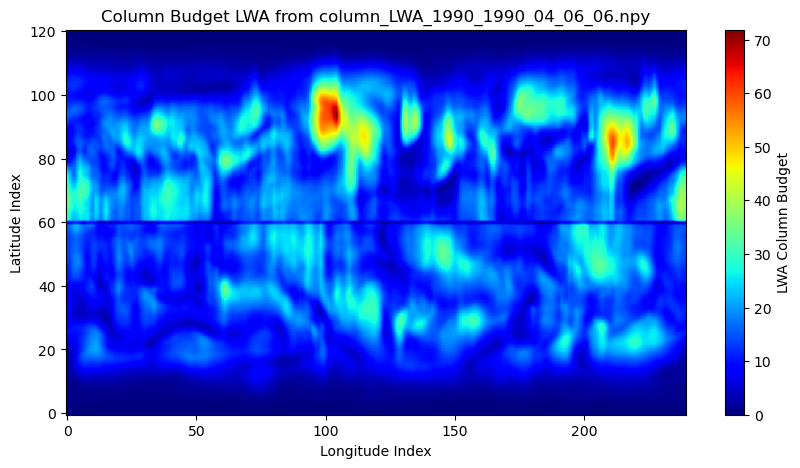

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_and_print_file(filename):
    # Load the numpy array
    data = np.load(filename)

    # Print the data
    print(data)

    # Plot the data as a 2D heatmap
    plt.figure(figsize=(10, 5))
    plt.imshow(data, cmap='jet', aspect='auto', origin='lower')
    plt.colorbar(label='LWA Column Budget')
    plt.title(f"Column Budget LWA from {os.path.basename(filename)}")
    plt.xlabel('Longitude Index')
    plt.ylabel('Latitude Index')
    plt.show()

# Example usage:
output_file = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/column_LWA_1990_1990_04_06_06.npy"
plot_and_print_file(output_file)


In [6]:
import numpy as np
import os
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

def column_budget_zonal_wind(zonal_wind_filename, output_directory, hh=7000.0, dz=1000.0):
    # Load zonal wind data
    zonal_wind_data = np.load(zonal_wind_filename)
    
    # Construct height array (0 to 48000 m in increments of 1000 m)
    z = np.arange(0, 49) * dz

    # Calculate the exponential decay factor
    decay_factor = np.exp(-z/hh)
    
    # Calculate weighted zonal wind and normalize
    weighted_zonal_wind = np.sum(zonal_wind_data * decay_factor[:, np.newaxis, np.newaxis], axis=0)
    normalization = np.sum(decay_factor)
    weighted_zonal_wind /= normalization

    # Define latitudes (assuming it's evenly spaced from -90 to 90)
    phi = np.linspace(-90, 90, 121)
    cos_phi = np.cos(np.deg2rad(phi))
    
    # Multiply by cosine of latitude
    column_budget = weighted_zonal_wind * cos_phi[:, np.newaxis]
    
    # Save the result
    output_filename = os.path.join(output_directory, "column_" + os.path.basename(zonal_wind_filename))
    np.save(output_filename, column_budget)


def process_all_files(directory, output_directory, num_threads=4):
    # List all zonal wind files in the directory
    zonal_wind_files = [f for f in os.listdir(directory) if f.startswith('zonal_wind_u_') and f.endswith('.npy')]
    zonal_wind_files_full = [os.path.join(directory, f) for f in zonal_wind_files]
    
    # Process files in parallel with progress bar
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        list(tqdm(executor.map(column_budget_zonal_wind, zonal_wind_files_full, [output_directory]*len(zonal_wind_files_full)), total=len(zonal_wind_files_full)))


# Main execution:
directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
output_directory = directory  # saving output in the same directory
process_all_files(directory, output_directory)


100%|██████████| 55064/55064 [18:17<00:00, 50.17it/s]


[[-3.30918522e-16 -3.43422985e-16 -3.55651168e-16 ... -2.92134783e-16
  -3.05276226e-16 -3.18206415e-16]
 [-1.33645252e-01 -1.39210590e-01 -1.44631616e-01 ... -1.16182962e-01
  -1.22132901e-01 -1.27955296e-01]
 [-3.10539009e-01 -3.27056282e-01 -3.43328322e-01 ... -2.59630449e-01
  -2.76767018e-01 -2.93795867e-01]
 ...
 [ 7.35750756e-01  7.24466988e-01  7.13279920e-01 ...  7.69535780e-01
   7.58298076e-01  7.47012082e-01]
 [ 2.54541974e-01  2.48152669e-01  2.41789028e-01 ...  2.73832032e-01
   2.67397259e-01  2.60969074e-01]
 [ 1.49684116e-16  1.38706847e-16  1.27621982e-16 ...  1.81864723e-16
   1.71257123e-16  1.60504577e-16]]


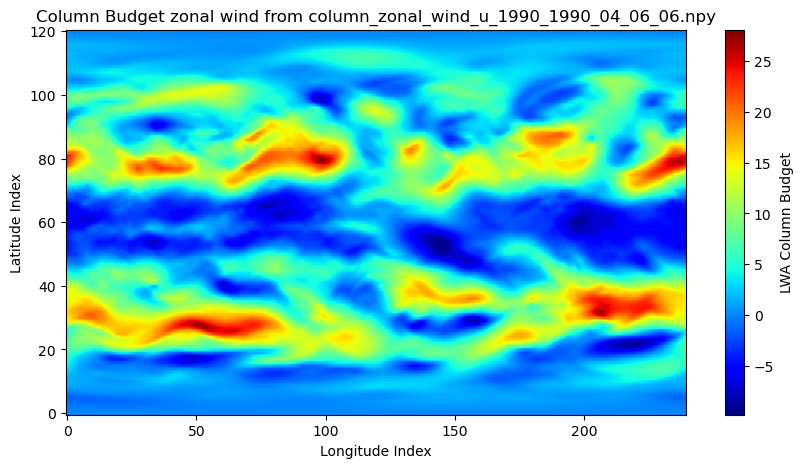

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_and_print_file(filename):
    # Load the numpy array
    data = np.load(filename)

    # Print the data
    print(data)

    # Plot the data as a 2D heatmap
    plt.figure(figsize=(10, 5))
    plt.imshow(data, cmap='jet', aspect='auto', origin='lower')
    plt.colorbar(label='LWA Column Budget')
    plt.title(f"Column Budget zonal wind from {os.path.basename(filename)}")
    plt.xlabel('Longitude Index')
    plt.ylabel('Latitude Index')
    plt.show()

# Example usage:
output_file = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/column_zonal_wind_u_1990_1990_04_06_06.npy"
plot_and_print_file(output_file)


In [1]:
# Extended Uref
import numpy as np
import os
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

def extend_and_save_Uref(Uref_filename, output_directory):
    # Load Uref data
    Uref_data = np.load(Uref_filename)
    
    # Extend dimension
    Uref_extended = np.tile(Uref_data[:,:,np.newaxis], (1, 1, 240))
    
    # Save the extended data
    output_filename = os.path.join(output_directory, "extended_" + os.path.basename(Uref_filename))
    np.save(output_filename, Uref_extended)

def process_Uref_files(directory, output_directory, num_threads=4):
    # List all Uref files in the directory
    Uref_files = [f for f in os.listdir(directory) if f.startswith('Uref_') and f.endswith('.npy')]
    Uref_files_full = [os.path.join(directory, f) for f in Uref_files]
    
    # Process files in parallel with progress bar
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        list(tqdm(executor.map(extend_and_save_Uref, Uref_files_full, [output_directory]*len(Uref_files_full)), total=len(Uref_files_full)))

# Main execution:
directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
output_directory = directory  # saving output in the same directory
process_Uref_files(directory, output_directory)


100%|██████████| 55064/55064 [20:49<00:00, 44.08it/s]  


In [2]:
import numpy as np

# Load the .npy file
# data = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/LWA_1990_1990_04_08_06.npy')
# data2 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/Interim_Slice_6hr/1979_1979_01_01_06_00_u.nc')
data3 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/extended_Uref_1990_1990_04_08_06.npy')
# data4 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/zonal_wind_u_1990_1990_04_08_06.npy')

# Print the shape of the data
# print(data.shape)
print(data3.shape)
# print(data4.shape)

(49, 121, 240)


In [3]:
import numpy as np
import os
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

def column_budget_Uref(zonal_wind_filename, output_directory, hh=7000.0, dz=1000.0):
    # Load zonal wind data
    zonal_wind_data = np.load(zonal_wind_filename)
    
    # Construct height array (0 to 48000 m in increments of 1000 m)
    z = np.arange(0, 49) * dz

    # Calculate the exponential decay factor
    decay_factor = np.exp(-z/hh)
    
    # Calculate weighted zonal wind and normalize
    weighted_zonal_wind = np.sum(zonal_wind_data * decay_factor[:, np.newaxis, np.newaxis], axis=0)
    normalization = np.sum(decay_factor)
    weighted_zonal_wind /= normalization

    # Define latitudes (assuming it's evenly spaced from -90 to 90)
    phi = np.linspace(-90, 90, 121)
    cos_phi = np.cos(np.deg2rad(phi))
    
    # Multiply by cosine of latitude
    column_budget = weighted_zonal_wind * cos_phi[:, np.newaxis]
    
    # Save the result
    output_filename = os.path.join(output_directory, "column_" + os.path.basename(zonal_wind_filename))
    np.save(output_filename, column_budget)


def process_all_files(directory, output_directory, num_threads=4):
    # List all zonal wind files in the directory
    zonal_wind_files = [f for f in os.listdir(directory) if f.startswith('extended_Uref_') and f.endswith('.npy')]
    zonal_wind_files_full = [os.path.join(directory, f) for f in zonal_wind_files]
    
    # Process files in parallel with progress bar
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        list(tqdm(executor.map(column_budget_Uref, zonal_wind_files_full, [output_directory]*len(zonal_wind_files_full)), total=len(zonal_wind_files_full)))


# Main execution:
directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
output_directory = directory  # saving output in the same directory
process_all_files(directory, output_directory)


100%|██████████| 55064/55064 [1:03:01<00:00, 14.56it/s]


(121, 240)


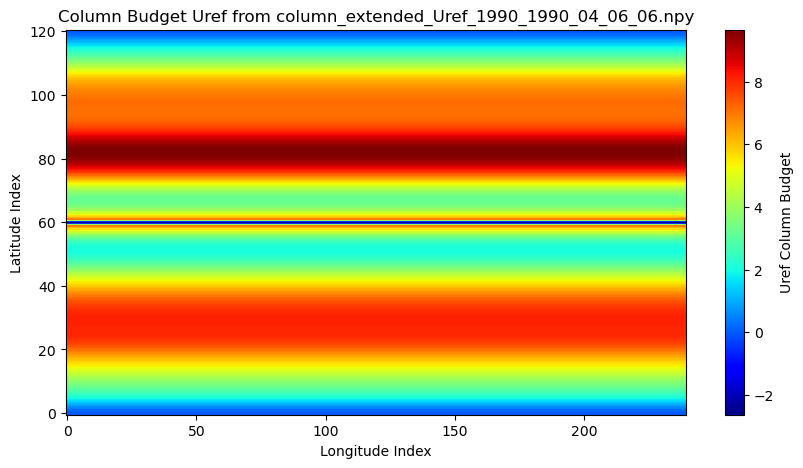

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_and_print_file(filename):
    # Load the numpy array
    data = np.load(filename)

    # Print the data
    print(data.shape)

    # Plot the data as a 2D heatmap
    plt.figure(figsize=(10, 5))
    plt.imshow(data, cmap='jet', aspect='auto', origin='lower')
    plt.colorbar(label='Uref Column Budget')
    plt.title(f"Column Budget Uref from {os.path.basename(filename)}")
    plt.xlabel('Longitude Index')
    plt.ylabel('Latitude Index')
    plt.show()

# Example usage:
output_file = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/column_extended_Uref_1990_1990_04_06_06.npy"
plot_and_print_file(output_file)


In [1]:
# <u>cos \phi
# !!!!!!not the right calculation!!!! stop here
import os
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import xarray as xr

def column_budget_from_nc(nc_filename, output_directory, hh=7000.0, dz=1000.0):
    # Load data from .nc file using xarray
    with xr.open_dataset(nc_filename) as ds:
        u_data = ds['u'].isel(time=0).values  # Selecting the first time point
        # Ensure the data shape is (37, 121, 240)
        assert u_data.shape == (37, 121, 240), "Data shape mismatch"

    # Construct height array (0 to 36000 m in increments of 1000 m) - Adjusting for 37 levels
    z = np.arange(0, 37) * dz
    decay_factor = np.exp(-z/hh)

    # Calculate weighted u and normalize
    weighted_u = np.sum(u_data * decay_factor[:, np.newaxis, np.newaxis], axis=0)
    normalization = np.sum(decay_factor)
    weighted_u /= normalization

    # Define latitudes (assuming it's evenly spaced from -90 to 90)
    phi = np.linspace(-90, 90, 121)
    cos_phi = np.cos(np.deg2rad(phi))

    # Multiply by cosine of latitude
    column_budget = weighted_u * cos_phi[:, np.newaxis]

    # Save the result
    output_filename = os.path.join(output_directory, "column_u_" + os.path.basename(nc_filename).replace('_u.nc', '.npy'))
    np.save(output_filename, column_budget)

def process_all_files(input_directory, output_directory, num_threads=4):
    # List all .nc files with _u.nc in the input directory
    u_files_full = [os.path.join(input_directory, f) for f in os.listdir(input_directory) if f.endswith('_u.nc')]

    # Process .nc files to calculate column budget
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        list(tqdm(executor.map(column_budget_from_nc, u_files_full, [output_directory]*len(u_files_full)), total=len(u_files_full)))

# Main execution:
input_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/Interim_Slice_6hr"
output_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
process_all_files(input_directory, output_directory)



100%|██████████| 55064/55064 [11:52<00:00, 77.30it/s]


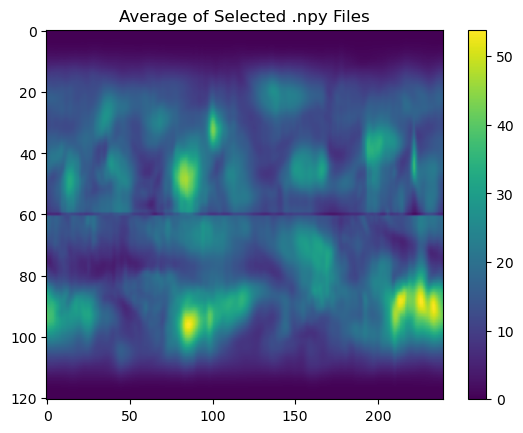

In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt

# Define path
folder_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/"

# List all files in the directory
all_files = os.listdir(folder_path)

# Use regex to filter the files
pattern = re.compile(r"column_LWA_1980_1980_01_(12|13|14|15)_[0-9]{2}.npy")
selected_files = [file for file in all_files if pattern.match(file)]

# Load the .npy files and compute the average
sum_array = None
count = 0

for file in selected_files:
    array = np.load(os.path.join(folder_path, file))
    
    if sum_array is None:
        sum_array = array
    else:
        sum_array += array
    count += 1

average_array = sum_array / count

# Plot the average array
plt.imshow(average_array, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title("Average of Selected .npy Files")
plt.show()


In [2]:
import numpy as np
import os
import re

# Define path
folder_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/"

# List all files in the directory
all_files = os.listdir(folder_path)

# Use regex to filter the files
pattern = re.compile(r"column_LWA_1980_1980_01_(12|13|14|15)_[0-9]{2}.npy")
selected_files = [file for file in all_files if pattern.match(file)]

# Load the .npy files and compute the average
sum_array = None
count = 0

for file in selected_files:
    array = np.load(os.path.join(folder_path, file))
    
    if sum_array is None:
        sum_array = array
    else:
        sum_array += array
    count += 1

average_array = sum_array / count

# Find and print the max point in the averaged array
max_val_avg = np.max(average_array)
max_loc_avg = np.unravel_index(np.argmax(average_array), average_array.shape)

print(f"In the averaged array -> Max Value: {max_val_avg} at Location: {max_loc_avg}")


In the averaged array -> Max Value: 53.869506530325076 at Location: (88, 226)
